In [1]:
import copy
import hashlib
import json
import requests
import time
import matplotlib.pyplot as plt
import os
from pprint import pprint
import shutil
from pathlib import Path
import random
import re
from maap.maap import MAAP
# invoke the MAAP constructor using the maap_host argument
maap = MAAP(maap_host='api.ops.maap-project.org')

# MAAP Data Store Performance Comparison with NASA Operational Data Store

In this notebook we compare the performance of downloading data from NASA's operational CMR vs the cost to access and store data in MAAP's S3 data store

## Step 1: Define some collections to test

The collections below are cataloged in both MAAP's CMR and NASA's Operational CMR. The MAAP versions exist in an S3 data store in us-west-2 (s3://nasa-maap-data-store). The NASA versions exist in on-prem data stores at various DAACs and are accessible over HTTPS.

In [2]:
POLARIMETRIC = {
    'short_name': 'Polarimetric_CT_1601',
    'version': '1',
    'concept_id': 'C1538765745-ORNL_DAAC',
    'provider': 'ORNL_DAAC',
    'granules': []
}
AfriSAR_AGB_Maps_1681 = {
    'short_name': 'AfriSAR_AGB_Maps_1681',
    'version': '1',
    'concept_id': 'C1612508242-ORNL_DAAC',
    'provider': 'ORNL_DAAC',
    'granules': []    
}
ABLVIS2 = {
    'short_name': 'ABLVIS2',
    'version': '1',
    'concept_id': 'C1513105984-NSIDC_ECS',
    'provider': 'NSIDC_ECS',
    'granules': []    
}
ALOS_PSR_RTC_HIGH = {
    'short_name': 'ALOS_PSR_RTC_HIGH',
    'version': '1',
    'concept_id': 'C1206487504-ASF',
    'provider': 'ASF',
    'granules': []    
}
ALOS_PSR_L15 = {
    'short_name': 'ALOS_PSR_L1.5',
    'version': '1',
    'concept_id': 'C1206485940-ASF',
    'provider': 'ASF',
    'granules': []
}
LVISF1B = {
    'short_name': 'LVISF1B',
    'version': '1',
    'concept_id': 'C1723866745-NSIDC_ECS',
    'provider': 'NSIDC_ECS',
    'granules': []
}
GEDIL2A = {
    'short_name': 'GEDI02_A',
    'version': '002',
    'concept_id': 'C1908348134-LPDAAC_ECS',
    'provider': 'LPDAAC_ECS',
    'granules': []
}
ATL08 = {
    'short_name': 'ATL08',
    'version': '005',
    'concept_id': 'C2144424132-NSIDC_ECS',
    'provider': 'NSIDC_ECS',
    'granules': []
}

collections = {
    collection['short_name']: collection for collection in
    [ POLARIMETRIC, AfriSAR_AGB_Maps_1681, ABLVIS2, ALOS_PSR_RTC_HIGH, ALOS_PSR_L15, LVISF1B, GEDIL2A, ATL08 ]
}
collection_results = copy.deepcopy(collections)

In [3]:
# Define some directories to store the data in temporarily.
nasa_operational_dir = 'test_files/nasa_operational'
maap_dir = 'test_files/maap'
Path(nasa_operational_dir).mkdir(parents=True, exist_ok=True)
Path(maap_dir).mkdir(parents=True, exist_ok=True)

In [4]:
# Function to capture time to download.
def time_download(granule, directory):
    download_start_time = time.time()
    nasa_file = granule.getData(directory)
    download_end_time = time.time()
    download_end_time - download_start_time 
    return [nasa_file, download_end_time - download_start_time ]

## Step 2: Test download

For each collection, download the granule from NASA's Operational Data Store and from MAAP's S3 data store. Also get the file size and make sure the checksums match.

In [5]:
limit = 100
times_per_collection = 5

for collection in collections.values():
    print(collection)
    maap_collection = {
        'short_name': collection['short_name'],
        'version': collection['version']
    }
    maap_search_results = maap.searchGranule(
        cmr_host='cmr.maap-project.org',
        limit=limit,
        **maap_collection
    )
    # Test a few random granules in this collection
    for idx in range(times_per_collection):
        granule = maap_search_results[random.randint(0, len(maap_search_results) - 1)]
        granule_ur = granule['Granule']['GranuleUR']
        print(f"Downloading {granule_ur} from MAAP")
        maap_file, maap_time = time_download(granule, maap_dir)
        print(f"Time to download from MAAP data store {maap_time}")
        maap_hexdigest = hashlib.md5(open(maap_file,'rb').read()).hexdigest()

        # NASA's operational CMR
        nasa_search_results = maap.searchGranule(
            cmr_host='cmr.earthdata.nasa.gov',
            limit=limit,
            granule_ur=granule_ur,
            **collection,
        )
        granule = nasa_search_results[0]  
        print(f"Downloading {granule['Granule']['GranuleUR']} from NASA")        
        nasa_file, nasa_time = time_download(granule, nasa_operational_dir)
        print(f"Time to download from nasa operational data store {nasa_time}")
        nasa_hexdigest = hashlib.md5(open(nasa_file,'rb').read()).hexdigest()
        # Make sure the files match
        print(nasa_hexdigest)
        print(maap_hexdigest)         
        assert(nasa_hexdigest == maap_hexdigest)       

        file_size = os.path.getsize(maap_file)        
        granule_results = {
            'granule_ur': granule_ur,
            'nasa_time': nasa_time,
            'maap_time': maap_time,
            'file_size': file_size,
            'time_ratio': nasa_time/maap_time
        }
        collection_results[collection['short_name']]['granules'].append(granule_results)


{'short_name': 'Polarimetric_CT_1601', 'version': '1', 'concept_id': 'C1538765745-ORNL_DAAC', 'provider': 'ORNL_DAAC', 'granules': []}
Time to download from MAAP data store 0.43908047676086426
Time to download from nasa operational data store 4.086672067642212
2481dca1d1267282511b986917ee77c4
2481dca1d1267282511b986917ee77c4
Time to download from MAAP data store 0.407010555267334
Time to download from nasa operational data store 3.3410191535949707
a331f16095cfaff560a9bf609893d598
a331f16095cfaff560a9bf609893d598
Time to download from MAAP data store 0.5069441795349121
Time to download from nasa operational data store 3.5780603885650635
3a96287fa538993409973c158acf8b42
3a96287fa538993409973c158acf8b42
Time to download from MAAP data store 0.3696436882019043
Time to download from nasa operational data store 3.2396702766418457
0838a83fc1ffcd445d0370c23715b2d4
0838a83fc1ffcd445d0370c23715b2d4
Time to download from MAAP data store 0.0021543502807617188
Time to download from nasa operational

## Step 3: Plot the data

As expected, we see that downloading the data from MAAP's S3 is faster. It takes anywhere from twice to 15 times as long to download data.

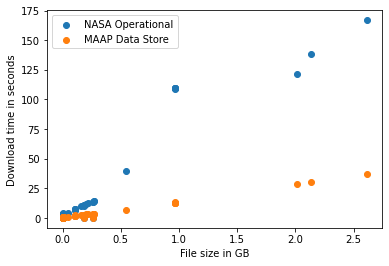

In [6]:
all_granules = []
[all_granules.extend(collection['granules']) for collection in collection_results.values()]
nasa_times = [granule['nasa_time'] for granule in all_granules]
maap_times = [granule['maap_time'] for granule in all_granules]
file_sizes = [granule['file_size']/1e9 for granule in all_granules]
ratios = [granule['time_ratio'] for granule in all_granules]

plt.scatter(file_sizes, nasa_times, label='NASA Operational')
plt.scatter(file_sizes, maap_times, label='MAAP Data Store')
plt.legend()
plt.xlabel('File size in GB')
plt.ylabel('Download time in seconds')
plt.show()

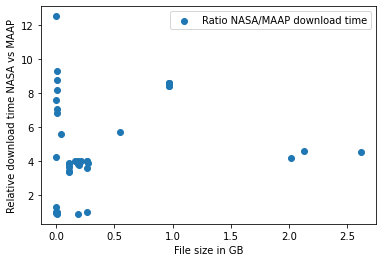

In [7]:
plt.scatter(file_sizes, ratios, label='Ratio NASA/MAAP download time')
plt.legend()
plt.xlabel('File size in GB')
plt.ylabel('Relative download time NASA vs MAAP')
plt.show()

In [10]:
import os

collection_directories = [f"{collection['short_name']}___{collection['version']}" for collection in collection_results.values()]
sizes = dict()

for dir in collection_directories:
    location = f"nasa-maap-data-store/file-staging/nasa-map/{dir}"
    print(f"s3://{location}/")
    cmd = f"aws s3 ls --summarize --human-readable --recursive s3://{location}/ | grep 'Total'"
    sizes[dir] = os.popen(cmd).read()
    print(sizes)

s3://nasa-maap-data-store/file-staging/nasa-map/Polarimetric_CT_1601___1/
{'Polarimetric_CT_1601___1': 'Total Objects: 104\n   Total Size: 448.5 MiB\n'}
s3://nasa-maap-data-store/file-staging/nasa-map/AfriSAR_AGB_Maps_1681___1/
{'Polarimetric_CT_1601___1': 'Total Objects: 104\n   Total Size: 448.5 MiB\n', 'AfriSAR_AGB_Maps_1681___1': 'Total Objects: 8\n   Total Size: 576.3 KiB\n'}
s3://nasa-maap-data-store/file-staging/nasa-map/ABLVIS2___1/
{'Polarimetric_CT_1601___1': 'Total Objects: 104\n   Total Size: 448.5 MiB\n', 'AfriSAR_AGB_Maps_1681___1': 'Total Objects: 8\n   Total Size: 576.3 KiB\n', 'ABLVIS2___1': 'Total Objects: 1051\n   Total Size: 103.9 GiB\n'}
s3://nasa-maap-data-store/file-staging/nasa-map/ALOS_PSR_RTC_HIGH___1/
{'Polarimetric_CT_1601___1': 'Total Objects: 104\n   Total Size: 448.5 MiB\n', 'AfriSAR_AGB_Maps_1681___1': 'Total Objects: 8\n   Total Size: 576.3 KiB\n', 'ABLVIS2___1': 'Total Objects: 1051\n   Total Size: 103.9 GiB\n', 'ALOS_PSR_RTC_HIGH___1': 'Total Objects:

In [16]:
total_size = 0

for sizes_str in sizes.values():
    volume_str_match = re.match('.+Total Size: (\d+.\d+) (\w)iB', sizes_str, flags=re.DOTALL)
    if volume_str_match:
        volume = volume_str_match[1]
        unit = volume_str_match[2]
        if unit == 'K':
            total_size += float(volume)*1024
        elif unit == 'M':
            total_size += float(volume)*1024*1024        
        elif unit == 'G':
            total_size += float(volume)*1024*1024*1024
        elif unit == 'T':
            total_size += float(volume)*1024*1024*1024*1024
    
total_size_in_gb = total_size/(1024*1024*1024)
total_size_in_gb

85575.53853788377

In [17]:
# average time to download data from NASA
` = (sum(nasa_times)/len(nasa_times))/sum(file_sizes)
average_time_per_gb

# total size of these collections
total_size_of_collections = total_size_in_gb # GB

# multiple average_time_per_gb times the total size of these 5 collections
total_time = average_time_per_gb * total_size_of_collections
total_time_in_hours = total_time / 60

# calculate the cost of compute for m5.large
total_cost_to_download_all = 0.096 * total_time_in_hours
f"total cost to download all: ${round(total_cost_to_download_all, 2)}"

'total cost to download all: $266.43'

In [18]:
# cost to archive + store all
cost_for_maap_data_store = total_size_of_collections * 0.0230000000
cost_for_maap_data_store

# cost to ingest + publish all
# Below we estimate the cost to run veda-data-pipeline lambdas for 1.2GB of data, which is from ICESat-2 Boreal publication Feb 21, 2023.
lambda_time_per_gb = 745604 / 1000 / 1.2
# cost for lambda execution time
lambda_time_for_for_all = lambda_time_per_gb * total_size_of_collections # for every GB-second
total_processing_cost = lambda_time_for_for_all * 0.0000166667 * 0.5 
print(f"Cost to catalog the data ${round(total_processing_cost, 2)} (incurred only once).")
print(f"Monthly cost to store the data ${round(cost_for_maap_data_store, 2)}")
print(f"Cost to catalog and store data for these collections is estimated at ${round(cost_for_maap_data_store + total_processing_cost, 2)}")

Cost to catalog the data $443.09 (incurred only once).
Monthly cost to store the data $1968.24
Cost to catalog and store data for these collections is estimated at $2411.33


## In conclusion

### The estimated cost to catalog and store data is comparable to downloading the same data from NASA's operational data store at least 5 times every month.

In the most recent test, the relative cost was actually 10 times - in other words the same data must be downloaded 10 times in order to cover the cost of storing the same data in S3.

Additional considerations:
* The estimated cost to transfer data in from NASA Operational Data Stores is only for EC2 compute time, the cost to transfer data into EC2 is $0, see https://aws.amazon.com/ec2/pricing/on-demand/#Data_Transfer.
* the DPS caches files, so downloading more than once may not be necessary.
* The estimate to create copies of data does not include development hours to maintain up to date archives. We estimate at least 1 FTE to maintain up to date copies of NASA data.
* In previous metrics, we found that only about 1% of the data is being accessed. See [NASA MAAP Data System Update: October 2022](https://docs.google.com/presentation/d/1mhlF-sVIBZXOyq_o0W6DiRgYp3y9fa_WfCFkZywYRlQ/edit#slide=id.g16ca19faf11_0_5)

<img src="aws_data_transfer_in_costs.png"  width="700" style="border: 1px solid #555;">

## Clean up

In [ ]:
shutil.rmtree('test_files')